In [105]:
import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, DiscriminationThreshold, PrecisionRecallCurve, ROCAUC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, f1_score
from yellowbrick.features import ParallelCoordinates, PCA, RadViz
from yellowbrick.model_selection import RFECV
from yellowbrick.style import set_palette

warnings.simplefilter("ignore", UserWarning)

set_palette("dark")
sns.set(rc={"figure.figsize":(8, 8)})

data_path = Path("../../data").resolve()
os.makedirs(data_path, exist_ok=True)

## Preprocessing

In [2]:
tracks_df = pd.read_parquet(data_path / "tracks_v3.pq")

print("tracks_df shape:", tracks_df.shape)
print("...where track_chart_months >= 1:",
      tracks_df[tracks_df["track_chart_months"] >= 1].shape)
print("...where track_chart_months >= 6:",
      tracks_df[tracks_df["track_chart_months"] >= 6].shape)
print("...where artist_country = US:",
      tracks_df[(tracks_df["artist_country"] == "US")].shape)
print("...where artist_country = US and track_chart_months >= 1:",
      tracks_df[(tracks_df["artist_country"] == "US") & (tracks_df["track_chart_months"] >= 1)].shape)
print("...where artist_country = US and track_chart_months >= 6:",
      tracks_df[(tracks_df["artist_country"] == "US") & (tracks_df["track_chart_months"] >= 6)].shape)

print("removing karaoke tracks")
tracks_df = tracks_df[~tracks_df["name"].str.lower().str.contains("karaoke")]
tracks_df = tracks_df[~tracks_df["name"].str.lower().str.contains("originally performed by")]
tracks_df = tracks_df[~tracks_df["name"].str.lower().str.contains("instrumental")]

print("tracks_df shape:", tracks_df.shape)
print("...where track_chart_months >= 1:",
      tracks_df[tracks_df["track_chart_months"] >= 1].shape)
print("...where track_chart_months >= 6:",
      tracks_df[tracks_df["track_chart_months"] >= 6].shape)
print("...where artist_country = US:",
      tracks_df[(tracks_df["artist_country"] == "US")].shape)
print("...where artist_country = US and track_chart_months >= 1:",
      tracks_df[(tracks_df["artist_country"] == "US") & (tracks_df["track_chart_months"] >= 1)].shape)
print("...where artist_country = US and track_chart_months >= 6:",
      tracks_df[(tracks_df["artist_country"] == "US") & (tracks_df["track_chart_months"] >= 6)].shape)

audio_features = [
    "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness",
    "instrumentalness", "liveness", "valence", "tempo", "time_signature",
]

artist_features = [
    "artist_chart_tracks",
    "artist_nominations",
    "artist_wins",
    "artist_releases",
    "artist_chart_months",
    "artist_chart_months_recently",
    "artist_releases_recently",
    # "major_label",
]


def chart_status(track):
    if track["track_chart_peak"] == 1:
        return "peaked"
    elif track["track_chart_months"] > 3:
        return "charted_3months"
    elif track["track_chart_months"] >= 1:
        return "charted"
    else:
        return "uncharted"


tracks_df["chart_status"] = tracks_df.apply(chart_status, axis=1)
tracks_df["chart_months"] = tracks_df["track_chart_months"].apply(lambda months: months if months <= 5 else 5)
tracks_df["has_female_artist"] = tracks_df["artist_gender"].apply(lambda gender: int("female" in gender))


def create_test_train_datasets(
        df, x_vars, months=1, test_size=0.40, random_state=42,
        y_label="track_chart_months"):
    df = df[x_vars + [y_label]]
    if "major_label" in df.columns:
        df = df.drop(columns="major_label")
    if "chart_status" in df.columns:
        df = df.drop(columns="chart_status")
    if "chart_months" in df.columns:
        df = df.drop(columns="chart_months")
    df = df.dropna()
    X = df.drop(columns=["track_chart_months"])
    y = (df["track_chart_months"] >= months).astype(int)
    return train_test_split(X, y, stratify=y, test_size=test_size,
                            random_state=random_state)


X_audio_train, X_audio_test, y_audio_train, y_audio_test = create_test_train_datasets(tracks_df, audio_features, months=1)
X_artist_train, X_artist_test, y_artist_train, y_artist_test = create_test_train_datasets(tracks_df, artist_features, months=1)

us_tracks_df = tracks_df[(tracks_df["artist_country"] == "US")]

tracks_df shape: (14967, 69)
...where track_chart_months >= 1: (3259, 69)
...where track_chart_months >= 6: (671, 69)
...where artist_country = US: (5817, 69)
...where artist_country = US and track_chart_months >= 1: (2090, 69)
...where artist_country = US and track_chart_months >= 6: (409, 69)
removing karaoke tracks
tracks_df shape: (14923, 69)
...where track_chart_months >= 1: (3220, 69)
...where track_chart_months >= 6: (662, 69)
...where artist_country = US: (5814, 69)
...where artist_country = US and track_chart_months >= 1: (2089, 69)
...where artist_country = US and track_chart_months >= 6: (409, 69)


In [62]:
tracks_df[audio_features].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,14921.000000,14921.000000,14921.000000,14921.000000,14921.000000,14921.000000,14921.000000,14921.000000,14921.000000,14921.000000,14921.000000,14921.000000
mean,0.648819,0.653054,5.309296,-6.580287,0.595805,0.106500,0.241888,0.037445,0.179747,0.505684,121.580153,3.958850
std,0.152102,0.186476,3.615535,3.054328,0.490752,0.104975,0.260063,0.155936,0.142385,0.230427,29.200819,0.297074
min,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.552000,0.537000,2.000000,-7.793000,0.000000,0.038300,0.034000,0.000000,0.094400,0.327000,98.001000,4.000000
50%,0.665000,0.676000,6.000000,-6.031000,1.000000,0.059400,0.141000,0.000000,0.123000,0.506000,120.045000,4.000000
75%,0.759000,0.794000,8.000000,-4.696000,1.000000,0.133000,0.374000,0.000118,0.221000,0.684000,140.003000,4.000000
max,0.983000,0.999000,11.000000,1.509000,1.000000,0.954000,0.996000,0.993000,0.986000,0.982000,230.186000,5.000000


In [11]:
tracks_df[artist_features].describe()

,artist_chart_tracks,artist_nominations,artist_wins,artist_releases,artist_chart_months,artist_chart_months_recently,artist_releases_recently,major_label
count,14923.000000,14923.000000,14923.000000,14923.000000,14923.000000,14923.000000,14923.000000,6363.000000
mean,3.308182,0.413523,0.140253,17.318368,7.678818,3.227166,10.399048,0.689926
std,6.117903,1.436946,0.663414,22.982106,19.783667,8.241838,15.900763,0.462560
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,5.000000,1.000000
75%,4.000000,0.000000,0.000000,24.000000,3.000000,1.000000,13.000000,1.000000
max,31.000000,26.000000,20.000000,334.000000,193.000000,87.000000,282.000000,1.000000


In [7]:
# tracks released in 2017 by artists who have not previously charted
tracks_new_artists_2017 = tracks_df[
    (tracks_df["year"] == 2017)
    & (tracks_df["artist_chart_months"] == 0)
    & (tracks_df["artist_country"] == "US")
    # & (tracks_df["artist_lifetime_chart_months"] >= 1)
    # & (tracks_df["track_chart_months"] >= 1)
][["artists", "name", "track_chart_months", "artist_chart_months", "artist_lifetime_chart_months"]]
tracks_new_artists_2017

,artists,name,track_chart_months,artist_chart_months,artist_lifetime_chart_months
82,"Dumpstaphunk, Trombone Shorty",Justice,0.0,0.0,0.0
114,Lee Brice,Rumor,2.0,0.0,5.0
144,Two Feet,Love Is a Bitch,0.0,0.0,0.0
212,Portugal. The Man,Feel It Still,9.0,0.0,9.0
359,Judah & the Lion,Suit And Jacket,0.0,0.0,0.0
...,...,...,...,...,...
14777,Russ,Cherry Hill,0.0,0.0,0.0
14850,"Lil Yachty, Migos",Peek A Boo,0.0,0.0,13.0
14851,Chikybombom La Pantera,Tengo La Personalidad,0.0,0.0,0.0
14860,Great Good Fine Ok,Take It or Leave It,0.0,0.0,0.0


## Null model

In [28]:
X_train, X_test, y_train, y_test = create_test_train_datasets(tracks_df, x_vars=[], months=1)
precision = precision_score(y_test,  [1] * len(y_test))
f1 = f1_score(y_test,  [1] * len(y_test))
print(f"null score (charted = 1 month): precision={1 - precision:.5f}, f1={1 - f1:.5f}, class size={(y_test == 1).sum()} ({(y_test == 1).sum() / len(y_test) * 100:.2f}%)")

X_train, X_test, y_train, y_test = create_test_train_datasets(tracks_df, x_vars=[], months=6)
precision = precision_score(y_test,  [1] * len(y_test))
f1 = f1_score(y_test,  [1] * len(y_test))
print(f"null score (charted = 6 month): precision={1 - precision:.5f}, f1={1 - f1:.5f}, class size={(y_test == 1).sum()} ({(y_test == 1).sum() / len(y_test) * 100:.2f}%)")

null score (charted = 1 month): precision=0.78390, f1=0.64460, class size=1291 (21.61%)
null score (charted = 6 month): precision=0.95564, f1=0.91505, class size=265 (4.44%)


## Pairwise distances

In [5]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.metrics import pairwise
from sklearn.preprocessing import StandardScaler

X_audio_train, X_audio_test, y_audio_train, y_audio_test = create_test_train_datasets(tracks_df, audio_features, months=1)

scaler = StandardScaler()
scaler.fit(X_audio_train)

X_audio_train = pd.DataFrame(scaler.transform(X_audio_train), index=X_audio_train.index, columns=X_audio_train.columns)
X_audio_test = pd.DataFrame(scaler.transform(X_audio_test), index=X_audio_test.index, columns=X_audio_test.columns)
train_pairwise_distances = pairwise_distances(X_audio_train, X_audio_train, metric="cosine")
test_pairwise_distances = pairwise_distances(X_audio_train, X_audio_test, metric="cosine")
train_pairwise_distances_df = pd.DataFrame(train_pairwise_distances, index=X_audio_train.index, columns=X_audio_train.index)
test_pairwise_distances_df = pd.DataFrame(test_pairwise_distances, index=X_audio_train.index, columns=X_audio_test.index)

train_distances = []
for idx, column in train_pairwise_distances_df.iteritems():
    x0 = (column * (1 - y_audio_train))
    x1 = (column * y_audio_train)
    train_distances.append({
        "index": idx,
        "mean_distance_uncharted": np.median(x0[x0 > 0].values),
        "mean_distance_charted": np.median(x1[x1 > 0].values),
    })
train_distances_df = pd.DataFrame(train_distances).set_index("index")

test_distances = []
for idx, column in test_pairwise_distances_df.iteritems():
    x0 = (column * (1 - y_audio_train))
    x1 = (column * y_audio_train)
    test_distances.append({
        "index": idx,
        "mean_distance_uncharted": np.median(x0[x0 > 0].values),
        "mean_distance_charted": np.median(x1[x1 > 0].values),
    })
test_distances_df = pd.DataFrame(test_distances).set_index("index")

# sims_df[
#     (sims_df["y_pred"] == 1)
#     &
#     (sims_df["y"] == 1)
# ]

In [6]:
distances_df = pd.concat([train_distances_df, test_distances_df])
tracks_df = pd.merge(tracks_df, distances_df, left_on=tracks_df.index, right_on=distances_df.index).drop(columns=["key_0"])
tracks_df["mean_distance_charted_delta"] = tracks_df["mean_distance_charted"] - tracks_df["mean_distance_uncharted"]

In [53]:
#df_ = X_audio_test.copy()
#df_["y"] = (tracks_df["track_chart_months"] > 1).astype(int)
#df_["y_pred"] = (model.predict_proba(X_test)[:,1] >= 0.60).astype(int)
#df_["y_prob"] = (model.predict_proba(X_test)[:,1])
#pred_chart = df_[(df_["y_pred"] == 1)]
#pred_df = pd.merge(tracks_df, pred_chart)[["year", "artists", "name", "y", "y_pred", "y_prob", "artist_chart_months", "artist_lifetime_chart_months"]].sort_values("y_prob", ascending=False)
#pred_df = pred_df[(pred_df["year"] >= 2010) & (pred_df["artist_chart_months"] == 0)]
#pred_df
# df_ = pd.merge(tracks_df, sims_df, left_on=tracks_df.index, right_on=sims_df.index)
# df_ = df_[(df_["year"] == 2010) & (df_["artist_chart_months"] == 0)]
# df_ = df_[["year", "artists", "name", "y", "y_pred", "0", "1", "artist_chart_months", "artist_lifetime_chart_months"]]
# df_.sort_values("1").head(50)

,year,artists,name,y,y_pred,0,1,artist_chart_months,artist_lifetime_chart_months
4635,2010,Orianthi,According To You,1,1,0.966848,0.800897,0.0,4.0
26,2010,Kesha,We R Who We R,0,1,0.969130,0.810846,0.0,10.0
1767,2010,Tinie Tempah,Written in the Stars (feat. Eric Turner),1,1,0.974892,0.811938,0.0,0.0
1361,2010,"Martin Solveig, Dragonette",Hello (feat. Dragonette),1,1,0.970280,0.826050,0.0,8.0
1394,2010,"Mark Ronson, MNDR",Bang Bang Bang (feat. MNDR),0,1,0.980909,0.826870,0.0,0.0
4948,2010,Taio Cruz,Dynamite,1,1,0.969353,0.831554,0.0,22.0
4216,2010,Breaking Benjamin,Blow Me Away - Soundtrack Version,0,1,0.994909,0.833175,0.0,0.0
2454,2010,Skrillex,Kill EVERYBODY,0,1,0.969585,0.851824,0.0,0.0
3234,2010,,Helele,1,1,0.978732,0.864116,0.0,0.0
2238,2010,Sleigh Bells,Riot Rhythm,0,1,0.957108,0.872588,0.0,0.0


## Model selection

In [70]:
# Notes: Right way to use SMOTE:
# Ref: https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7

import itertools
import warnings

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import mplcyberpunk
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbalancedPipeline
from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklego.meta import Thresholder
from yellowbrick.style import set_palette


def score_model(model, X, y):
    return {
        "precision": precision_score(y, model.predict(X)),
        "recall": recall_score(y, model.predict(X)),
        "accuracy": accuracy_score(y, model.predict(X)),
        "f1": f1_score(y, model.predict(X)),
        "auc": roc_auc_score(y, model.predict(X)),
    }


def plot_classification_reports(model, X_train, X_test, y_train, y_test):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    visualgrid = [
        ConfusionMatrix(model, ax=axes[0], cmap="PuBu", classes=[0, 1], encoder={0: "Uncharted", 1: "Charted"}),
        ClassificationReport(model, ax=axes[1], cmap="PuBu", support=False, classes=[0, 1], encoder={0: "Uncharted", 1: "Charted"}),
        ROCAUC(model, ax=axes[2], macro=False, micro=False, per_class=True, classes=[0, 1], encoder={0: "Uncharted", 1: "Charted"}),
        PrecisionRecallCurve(model, micro=False, ax=axes[3], classes=[0, 1], encoder={0: "Uncharted", 1: "Charted"}),
    ]
    for viz in visualgrid:
        viz.fit(X_train, y_train)
        viz.score(X_test, y_test)
        viz.finalize()
    plt.show()

In [10]:
months = 1
artist_releases_features = ["artist_releases_recently"]
audio_backward_selected_features = ["acousticness", "danceability", "energy", "loudness"]
audio_selected_features_1_month = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
distance_features = ["mean_distance_uncharted", "mean_distance_charted", "mean_distance_charted_delta"]

features = [
    # ("All", audio_features + artist_features),
    # ("Artist", artist_features),
    ("Audio", audio_features),
    ("Audio+ArtistReleases", audio_features + artist_releases_features),
    ("Audio-BS", audio_backward_selected_features),
    ("Audio-BS+ArtistReleases", audio_backward_selected_features + artist_releases_features),
    ("Audio-RFE", audio_selected_features_1_month),
    ("Audio-RFE+ArtistReleases", audio_selected_features_1_month + artist_releases_features),
    ("Audio-RFE+Distances", audio_selected_features_1_month + distance_features),
    ("Audio-RFE+ArtistReleases+Distances", audio_selected_features_1_month + artist_releases_features + distance_features),
    ("Distances", distance_features),
    ("ArtistReleases+Distances", artist_releases_features + distance_features),
]

models = [
    ("LR-L1", LogisticRegressionCV(
        penalty="l1",
        cv=5,
        max_iter=100,
        class_weight="balanced",
        scoring=make_scorer(precision_score),
        solver="liblinear"
    )),
    ("LR-L2", LogisticRegressionCV(
        penalty="l2",
        cv=5,
        max_iter=100,
        class_weight="balanced",
        scoring=make_scorer(precision_score),
        solver="lbfgs"
    )),
    ("RF", RandomForestClassifier(
        max_depth=30,
        max_leaf_nodes=50,
        min_impurity_decrease=0.001,
        min_samples_split=5,
        random_state=23,
        class_weight="balanced",
    )),
    ("RF-Tuned", RandomForestClassifier(
        min_samples_split=5,
        min_impurity_decrease=0.0001,
        max_leaf_nodes=125,
        max_depth=40
    )),
    ("SVM-Poly", SVC(
        kernel="poly",
        gamma="auto",
        degree=2,
        probability=True,
        random_state=23,
        class_weight="balanced",
    )),
    ("SVM-RBF", SVC(
        gamma="auto",
        probability=True,
        random_state=23,
        class_weight="balanced",
    )),
    # ("DT", DecisionTreeClassifier(
    #      random_state=23,
    #      class_weight="balanced",
    # )),
    # ("MLP", MLPClassifier(
    #    hidden_layer_sizes=(10,),
    #    activation="logistic",
    #    solver="lbfgs",
    #    random_state=23,
    #    max_iter=5000
    # )),
    ("MLP-Tuned", MLPClassifier(
        hidden_layer_sizes=(10, 20),
        learning_rate="constant",
        activation="tanh",
        solver="lbfgs",
        random_state=1,
        max_iter=500
    )),

]

us_tracks_df = tracks_df[(tracks_df["artist_country"] == "US")]

datasets = [
    ("Global", tracks_df),
    ("US", us_tracks_df),
]

train_test_datasets = {}
model_scores = []

for (dataset_name, dataset), months in itertools.product(datasets, [1, 6]):
    # create train-test split with final holdout set for hyperparameter tuning.
    # print(dataset_name, dataset.shape)
    X_train, X_holdout, y_train, y_holdout = create_test_train_datasets(
        dataset, audio_features + artist_features + distance_features, months=months, test_size=0.25)
    train_validation_df = X_train.copy()
    train_validation_df["track_chart_months"] = y_train * months  # hack
    # print("tvdf y=0:", train_validation_df[train_validation_df["track_chart_months"] == 0].shape)
    # print("tvdf y=1:", train_validation_df[train_validation_df["track_chart_months"] == 1].shape)

    dataset_key = f"{dataset_name}-{months}"
    # train_test_datasets[dataset_key] = {
    #    "dataset": dataset_name,
    #    "months": months,
    #    "X_train": X_train,
    #    "X_holdout": X_holdout,
    #    "y_train": y_train,
    #    "y_holdout": y_holdout,
    #    "train_validation": train_validation_df,
    #}

    for (feature_name, features_), (model_name, model) in itertools.product(features, models):
        print(dataset_key, model_name, feature_name)

        X_train, X_test, y_train, y_test = create_test_train_datasets(train_validation_df, features_, months=months)
        # print("y_train", y_train[y_train == 0].shape, y_train[y_train == 1].shape)
        # print("y_test:", y_test[y_test == 0].shape, y_test[y_test == 1].shape)

        pipeline = ImbalancedPipeline([
            ("smote", SMOTE(random_state=42)),
            ("scaler", StandardScaler()),
            ("classifier", model),
        ])
        try:
            pipeline.fit(X_train, y_train)
        except ValueError as err:
            print(f"Could not fit: {err}")
            continue
        except Exception as err:
            print(f"Unknown error: {err}")
            continue

        model_score = {
            "name": f"{dataset_name}-{model_name}-{feature_name}",
            "dataset": dataset_key,
            "features": feature_name,
            "model": model_name,
            "months": months,
        }
        model_score.update(score_model(pipeline, X_test, y_test))
        model_scores.append(model_score)
        print(model_score)

        # plot_classification_reports(pipeline, X_train, X_test, y_train, y_test)

Global-1 LR-L1 Audio
{'name': 'Global-LR-L1-Audio', 'dataset': 'Global-1', 'features': 'Audio', 'model': 'LR-L1', 'months': 1, 'precision': 0.2835758835758836, 'recall': 0.7067357512953368, 'accuracy': 0.5518319928507596, 'f1': 0.4047477744807122, 'auc': 0.6079961866701691}
Global-1 LR-L2 Audio
{'name': 'Global-LR-L2-Audio', 'dataset': 'Global-1', 'features': 'Audio', 'model': 'LR-L2', 'months': 1, 'precision': 0.2813278008298755, 'recall': 0.7025906735751295, 'accuracy': 0.5489276139410187, 'f1': 0.4017777777777778, 'auc': 0.6046419616807576}
Global-1 RF Audio
{'name': 'Global-RF-Audio', 'dataset': 'Global-1', 'features': 'Audio', 'model': 'RF', 'months': 1, 'precision': 0.2877070619006103, 'recall': 0.34196891191709844, 'accuracy': 0.675603217158177, 'f1': 0.3125, 'auc': 0.5546358373313774}
Global-1 RF Audio
{'name': 'Global-RF-Audio', 'dataset': 'Global-1', 'features': 'Audio', 'model': 'RF', 'months': 1, 'precision': 0.29646017699115046, 'recall': 0.277720207253886, 'accuracy': 0.7

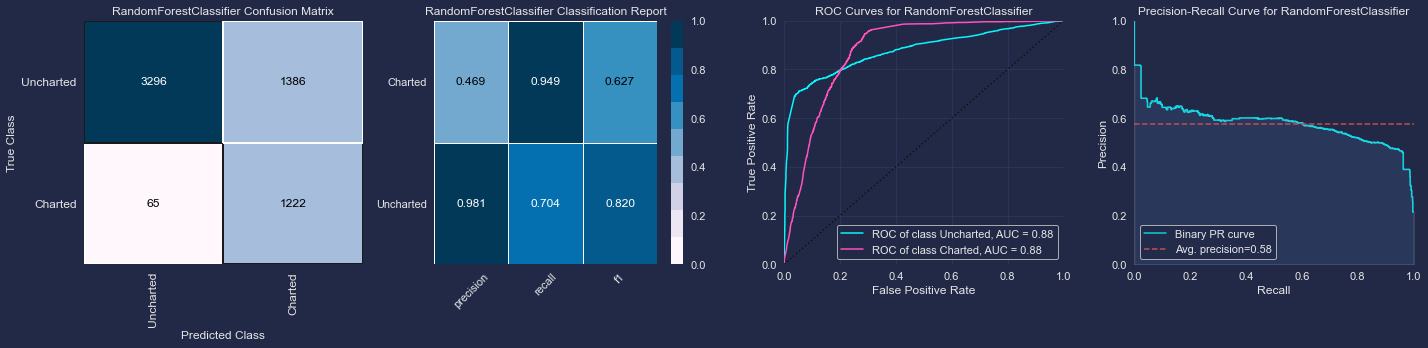

In [86]:
# Plot artist feature model

model = RandomForestClassifier(
    min_samples_split=5,
    min_impurity_decrease=0.0001,
    max_leaf_nodes=125,
    max_depth=40
)

pipeline = ImbalancedPipeline([
    ("smote", SMOTE(random_state=42)),
    ("scaler", StandardScaler()),
    ("classifier", model),
])
X_train, X_test, y_train, y_test = create_test_train_datasets(tracks_df, artist_features, months=1)
pipeline.fit(X_train, y_train)
plot_classification_reports(pipeline, X_train, X_test, y_train, y_test)

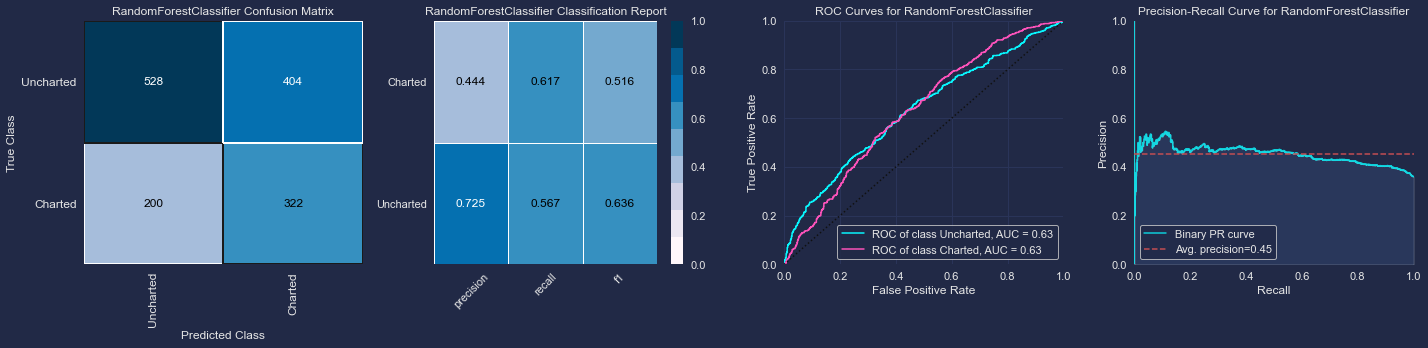

In [90]:
# Otherwise, best other model:

model = RandomForestClassifier(
    min_samples_split=5,
    min_impurity_decrease=0.0001,
    max_leaf_nodes=125,
    max_depth=40
)

pipeline = ImbalancedPipeline([
    ("smote", SMOTE(random_state=42)),
    ("scaler", StandardScaler()),
    ("classifier", model),
])
X_train, X_test, y_train, y_test = create_test_train_datasets(us_tracks_df, audio_selected_features_1_month + artist_releases_features, months=1, test_size=0.25)
pipeline.fit(X_train, y_train)
plot_classification_reports(pipeline, X_train, X_test, y_train, y_test)

In [104]:
# Tuning threshold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)


def fine_tune_model(model, param_grid, X_train, y_train, n_iter=100):
    stratified_kfold = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=42
    )

    pipeline = ImbalancedPipeline([
        ("smote", SMOTE(random_state=42)),
        ("scaler", StandardScaler()),
        ("classifier", model),
    ])

    gs = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        scoring=make_scorer(roc_auc_score),
        refit="auc",
        cv=stratified_kfold,
        n_jobs=-1,
        n_iter=n_iter,
    )

    gs.fit(X_train, y_train)
    print(f"best model: {gs.best_params_}")
    best_model = RandomForestClassifier(**{k.replace("classifier__", ""): v for k, v in gs.best_params_.items()})

    threshold_pipeline = ImbalancedPipeline([
        ("smote", SMOTE(random_state=42)),
        ("scaler", StandardScaler()),
        ("classifier", Thresholder(model, threshold=0.5)),
    ])

    threshold_gs = RandomizedSearchCV(
        estimator=threshold_pipeline,
        param_distributions={
            "classifier__threshold": np.linspace(0.2, 0.8, 200),
        },
        scoring={
            "precision": make_scorer(precision_score),
            "recall": make_scorer(recall_score),
            "accuracy": make_scorer(accuracy_score),
            "f1": make_scorer(f1_score),
            "auc": make_scorer(roc_auc_score),
        },
        refit="precision",
        cv=stratified_kfold,
        n_jobs=-1,
        n_iter=n_iter,
    )

    threshold_gs.fit(X_train, y_train)

    threshold_df = (
        pd.DataFrame(threshold_gs.cv_results_)
            .sort_values("param_classifier__threshold")
            .set_index("param_classifier__threshold")
            [["mean_test_precision", "mean_test_recall", "mean_test_accuracy", "mean_test_f1"]]
            .rename(columns={
                "mean_test_precision": "precision",
                "mean_test_recall": "recall",
                "mean_test_accuracy": "accuracy",
                "mean_test_f1": "f1",

        })
    )

    best_precision = np.max(threshold_df["f1"])
    best_precision_threshold = threshold_df.index[np.argmax(threshold_df["f1"])]

    print(f"best precision: precision={best_precision} @ threshold={best_precision_threshold}")
    threshold_df.plot(figsize=(10, 3))

    return Thresholder(model, threshold=best_precision_threshold)


model = Thresholder(
    RandomForestClassifier(**{
        'n_estimators': 1000,
        'min_samples_split': 5,
        'min_impurity_decrease': 0,
        'max_leaf_nodes': 100,
        'max_depth': 20
    }),
    threshold=0.49
)

param_grid = {
    "classifier__n_estimators": [100, 250, 500, 750, 1000],
    "classifier__min_samples_split": [5, 20, 35, 50],
    "classifier__max_leaf_nodes": [50, 75, 100, 125],
    "classifier__min_impurity_decrease": [0, .0001, .001],
    "classifier__max_depth": [20, 40, 60, 80, 100],
}

features = audio_features + ["artist_releases_recently"]
X_train, X_test, y_train, y_test = create_test_train_datasets(tracks_df, features, months=1)

model = fine_tune_model(model, param_grid, X_train, y_train, n_iter=20)
plot_classification_reports(model, X_train, X_test, y_train, y_test)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

ValueError: Invalid parameter n_estimators for estimator Thresholder(model=RandomForestClassifier(max_depth=20, max_leaf_nodes=100,
                                         min_impurity_decrease=0,
                                         min_samples_split=5,
                                         n_estimators=1000),
            threshold=0.49). Check the list of available parameters with `estimator.get_params().keys()`.

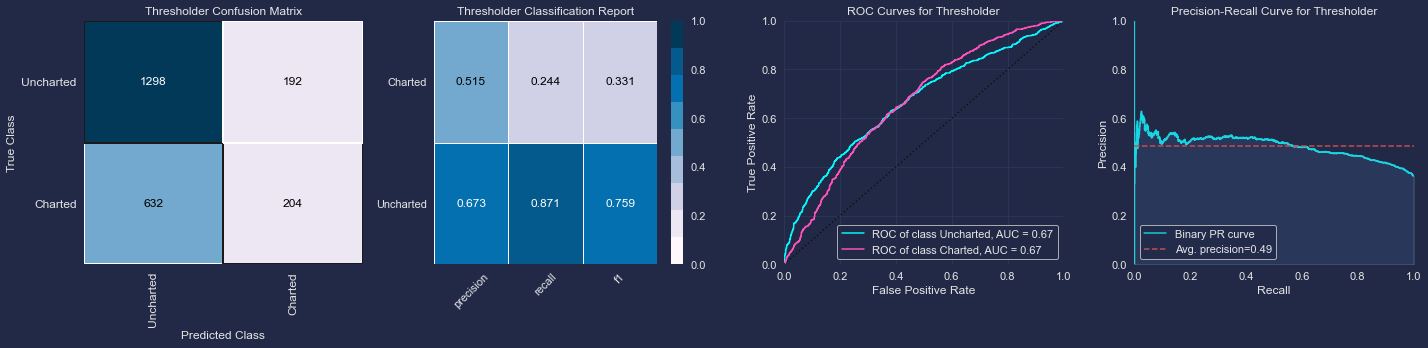

In [97]:
model = Thresholder(
    RandomForestClassifier(**{
        'n_estimators': 1000,
        'min_samples_split': 5,
        'min_impurity_decrease': 0,
        'max_leaf_nodes': 100,
        'max_depth': 20
    }),
    threshold=0.49
)
X_train, X_test, y_train, y_test = create_test_train_datasets(us_tracks_df, features, months=1)
plot_classification_reports(model, X_train, X_test, y_train, y_test)

In [143]:
tracks_df.columns

Index(['id', 'name', 'album', 'album_id', 'artists', 'artist_ids',
       'track_number', 'disc_number', 'explicit', 'duration_ms', 'year',
       'release_date', 'popularity', 'audio_features', 'isrc', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_chart_months', 'track_chart_indicativerevenue',
       'track_chart_peak', 'track_chart_mean', 'track_chart_median',
       'recording_award_category', 'recording_award_nominee',
       'recording_award_winner', 'album_award_category', 'album_award_nominee',
       'album_award_winner', 'num_artists', 'artist_matched', 'artist_names',
       'artist_genres', 'artist_popularity', 'artist_first_release',
       'artist_lifetime_releases', 'artist_gender', 'artist_country',
       'artist_hometown', 'artist_first_win', 'artist_first_nomination',
       'artist_lifetime_wins', 'artist_lifetime_nominations',
    

In [151]:
tracks_df[(tracks_df["artist_country"] == "US") & (tracks_df["track_chart_months"] >= 1)]

,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,duration_ms,...,artist_chart_months_recently,artist_releases_recently,genre,label_name,major_label,label_matched,chart_status,award_status,chart_months,has_female_artist
13,6ej1QJ8eIYmhsyTlvgDajy,Where I Come From,34 Number Ones,26w8J2SKCxa80Bwq6G8ctN,Alan Jackson,"[""4mxWe1mtYIYfP040G38yvS""]",30,1,False,239240,...,0.0,4.0,country road,None,NaN,NaN,charted,0,1.0,0
16,20FZrLl9zSbO9b3DhaqO6M,23,23,5r7L8DlTsIKoDwSSiRf5M7,"Mike WiLL Made-It, Miley Cyrus, Wiz Khalifa, J...","[""0NWbwDZY1VkRqFafuQm6wk"", ""5YGY8feqx7naU7z4Hr...",1,1,True,252520,...,18.0,18.0,pittsburgh rap,None,NaN,NaN,charted_3months,0,5.0,0
22,4BXkf6yww23Vdju7E1fUrn,Whiskey Lullaby (feat. Alison Krauss),Hits Alive,10XgYRGRtKApBh2P1K9yHS,"Brad Paisley, Alison Krauss","[""13YmWQJFwgZrd4bf5IjMY4"", ""5J6L7N6B4nI1M5cwa2...",12,1,False,259453,...,0.0,10.0,bluegrass,None,NaN,NaN,charted,0,1.0,1
30,2TZ1apxMDlubCGMsOxcTbT,Come Clean,Metamorphosis,2zfZe8P8jg53kZaAfCdBYs,Hilary Duff,"[""2S9W9aSAd7e5mp8WqWxN2h""]",2,1,False,214560,...,0.0,0.0,post-teen pop,None,NaN,NaN,charted,0,2.0,1
34,2WZyfujzMweFLnozyUJBkW,Boston,All The Stars and Boulevards,36i3fUi7xuuE0UA8pXtdxK,Augustana,"[""61YE3whKiuRr83j1yOm5M7""]",4,1,False,245933,...,0.0,0.0,acoustic pop,None,NaN,NaN,charted,0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14943,3U8dHeggJ8IBe0UCb1gbyB,Colder Weather,You Get What You Give,7xnimikDuIBDpLeLrjptb8,Zac Brown Band,"[""6yJCxee7QumYr820xdIsjo""]",8,1,False,273893,...,5.0,2.0,modern country rock,None,NaN,NaN,charted,0,1.0,0
14946,7LkQBDAiS0GVSO5JQuYDzY,In My Daughter's Eyes,Martina,3xtQSAQgeAV6TcvzyF4iDd,Martina McBride,"[""3P33qFNGBVXl86yQYWspFj""]",9,1,False,193800,...,4.0,0.0,country dawn,None,NaN,NaN,charted,0,1.0,1
14950,3oXNIpoUMdk8qGkwCeXqGv,Halfcrazy,Juslisen,070dWVyJIxcKQmxPRov0Y5,Musiq Soulchild,"[""3UVRliakQfa1pMWIsNuiZ8""]",7,1,False,254493,...,6.0,2.0,quiet storm,None,NaN,NaN,charted_3months,0,4.0,0
14963,6I6NX6tjGsxFAsIfGzY9lJ,Deja Vu,4 Your Eyez Only,3CCnGldVQ90c26aFATC1PW,J. Cole,"[""6l3HvQ5sa6mXTsMTB19rO5""]",3,1,True,264746,...,0.0,4.0,conscious hip hop,None,NaN,NaN,charted,0,1.0,0


In [186]:
sns.barplot(x=model_scores_df["name"], y=model_scores_df[["auc", "precision"]])

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [79]:
model_scores_df = pd.DataFrame(model_scores)
model_scores_df.sort_values("precision", ascending=False).drop(columns="name")

,dataset,features,model,months,precision,recall,accuracy,f1,auc
178,US-1,Audio-RFE+ArtistReleases,RF,1,0.484480,0.572568,0.627294,0.524854,0.615290
149,US-1,Audio+ArtistReleases,RF,1,0.480292,0.524721,0.625000,0.501524,0.603005
191,US-1,Audio-RFE+ArtistReleases+Distances,RF,1,0.473952,0.594896,0.616972,0.527581,0.612130
194,US-1,Audio-RFE+ArtistReleases+Distances,SVM-RBF,1,0.467033,0.677831,0.606078,0.553025,0.621816
177,US-1,Audio-RFE+ArtistReleases,RF,1,0.466069,0.580542,0.610092,0.517045,0.603610
...,...,...,...,...,...,...,...,...,...
90,Global-6,Audio-BS,MLP-Tuned,6,0.050537,0.404040,0.637846,0.089837,0.526354
88,Global-6,Audio-BS,SVM-Poly,6,0.050296,0.772727,0.344504,0.094444,0.548706
130,Global-6,Distances,SVM-Poly,6,0.049743,0.878788,0.252011,0.094156,0.550895
87,Global-6,Audio-BS,RF,6,0.049658,0.292929,0.720733,0.084919,0.516731


In [62]:
model_scores_df = pd.DataFrame(model_scores)
model_scores_df.sort_values("precision", ascending=False).drop(columns="name").head(20)

,dataset,features,model,months,precision,recall,accuracy,f1,auc
178,US-1,Audio-RFE+ArtistReleases,RF,1,0.484480,0.572568,0.627294,0.524854,0.615290
149,US-1,Audio+ArtistReleases,RF,1,0.480292,0.524721,0.625000,0.501524,0.603005
191,US-1,Audio-RFE+ArtistReleases+Distances,RF,1,0.473952,0.594896,0.616972,0.527581,0.612130
194,US-1,Audio-RFE+ArtistReleases+Distances,SVM-RBF,1,0.467033,0.677831,0.606078,0.553025,0.621816
177,US-1,Audio-RFE+ArtistReleases,RF,1,0.466069,0.580542,0.610092,0.517045,0.603610
150,US-1,Audio+ArtistReleases,RF,1,0.465798,0.456140,0.616399,0.460919,0.581248
170,US-1,Audio-RFE,RF,1,0.465476,0.623604,0.607225,0.533061,0.610817
152,US-1,Audio+ArtistReleases,SVM-RBF,1,0.464891,0.612440,0.607225,0.528562,0.608369
192,US-1,Audio-RFE+ArtistReleases+Distances,RF,1,0.464286,0.559809,0.609518,0.507592,0.598615
184,US-1,Audio-RFE+Distances,RF,1,0.463357,0.625199,0.604931,0.532247,0.609377


In [58]:
model_scores_df

,name,dataset,features,model,months,precision,recall,accuracy,f1,auc
0,Global-LR-L1-Audio,Global-1,Audio,LR-L1,1,0.283576,0.706736,0.551832,0.404748,0.607996
1,Global-LR-L2-Audio,Global-1,Audio,LR-L2,1,0.281328,0.702591,0.548928,0.401778,0.604642
2,Global-RF-Audio,Global-1,Audio,RF,1,0.287707,0.341969,0.675603,0.312500,0.554636
3,Global-RF-Audio,Global-1,Audio,RF,1,0.296460,0.277720,0.702189,0.286784,0.548288
4,Global-SVM-Poly-Audio,Global-1,Audio,SVM-Poly,1,0.268460,0.527461,0.588248,0.355820,0.566208
...,...,...,...,...,...,...,...,...,...,...
275,US-RF-ArtistReleases+Distances,US-6,ArtistReleases+Distances,RF,6,0.094463,0.471545,0.643922,0.157395,0.564273
276,US-RF-ArtistReleases+Distances,US-6,ArtistReleases+Distances,RF,6,0.090909,0.390244,0.681766,0.147465,0.547065
277,US-SVM-Poly-ArtistReleases+Distances,US-6,ArtistReleases+Distances,SVM-Poly,6,0.079518,0.804878,0.329128,0.144737,0.548954
278,US-SVM-RBF-ArtistReleases+Distances,US-6,ArtistReleases+Distances,SVM-RBF,6,0.101611,0.666667,0.560780,0.176344,0.609706


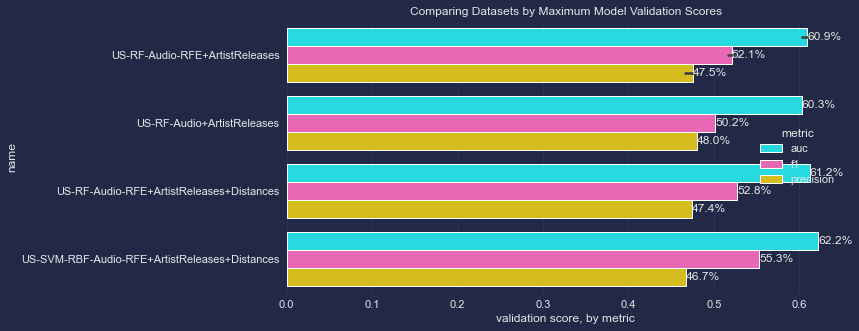

In [60]:
fig, ax1 = plt.subplots(figsize=(10, 5))
tidy = model_scores_df.sort_values("precision", ascending=False).head(5).melt(id_vars="name", value_vars=["auc", "f1", "precision"])
tidy["metric"] = tidy["variable"]
tidy["validation score, by metric"] = tidy["value"]
ax = sns.barplot(y="name", x='validation score, by metric', hue='metric', data=tidy, ax=ax1)
sns.despine(fig)
for container in ax.containers:
    ax.bar_label(container, labels=[f"{score*100:.1f}%" for score in container.datavalues])
ax.set_title("Comparing Datasets by Maximum Model Validation Scores");

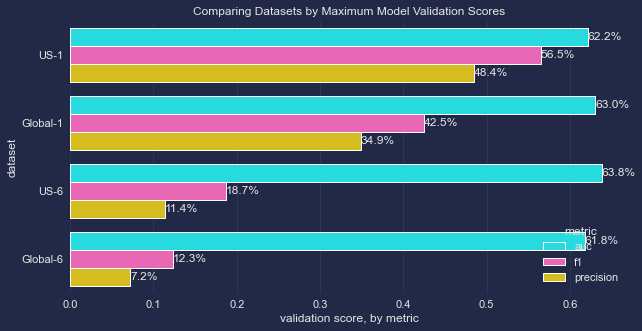

In [56]:
grouped_model_scores_df = (
    model_scores_df
        .groupby("dataset")
        .aggregate({
            # "precision": ["max", "mean", "median"],
            # "auc": ["max", "mean", "median"],
            # "f1": ["max", "mean", "median"],
            "precision": "max",
            "auc": "max",
            "f1": "max",
        })
        .reset_index()
)
fig, ax1 = plt.subplots(figsize=(10, 5))
tidy = grouped_model_scores_df.sort_values("precision", ascending=False).head(5).melt(id_vars="dataset", value_vars=["auc", "f1", "precision"])
tidy["metric"] = tidy["variable"]
tidy["validation score, by metric"] = tidy["value"]
ax = sns.barplot(y="dataset", x='validation score, by metric', hue='metric', data=tidy, ax=ax1)
sns.despine(fig)
for container in ax.containers:
    ax.bar_label(container, labels=[f"{score*100:.1f}%" for score in container.datavalues])
ax.set_title("Comparing Datasets by Maximum Model Validation Scores");

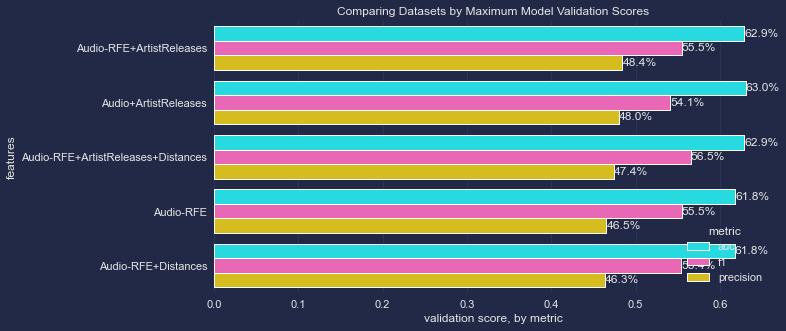

In [65]:
grouped_model_scores_df = (
    model_scores_df
        .groupby("features")
        .aggregate({
            # "precision": ["max", "mean", "median"],
            # "auc": ["max", "mean", "median"],
            # "f1": ["max", "mean", "median"],
            "precision": "max",
            "auc": "max",
            "f1": "max",
        })
        .reset_index()
)
fig, ax1 = plt.subplots(figsize=(10, 5))
tidy = grouped_model_scores_df.sort_values("precision", ascending=False).head(5).melt(id_vars="features", value_vars=["auc", "f1", "precision"])
tidy["metric"] = tidy["variable"]
tidy["validation score, by metric"] = tidy["value"]
ax = sns.barplot(y="features", x='validation score, by metric', hue='metric', data=tidy, ax=ax1)
sns.despine(fig)
for container in ax.containers:
    ax.bar_label(container, labels=[f"{score*100:.1f}%" for score in container.datavalues])
ax.set_title("Comparing Datasets by Maximum Model Validation Scores");

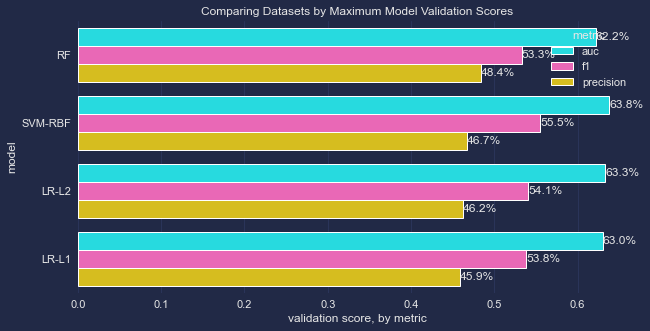

In [68]:
grouped_model_scores_df = (
    model_scores_df
        .groupby("model")
        .aggregate({
            # "precision": ["max", "mean", "median"],
            # "auc": ["max", "mean", "median"],
            # "f1": ["max", "mean", "median"],
            "precision": "max",
            "auc": "max",
            "f1": "max",
        })
        .reset_index()
)
fig, ax1 = plt.subplots(figsize=(10, 5))
tidy = grouped_model_scores_df.sort_values("precision", ascending=False).head(4).melt(id_vars="model", value_vars=["auc", "f1", "precision"])
tidy["metric"] = tidy["variable"]
tidy["validation score, by metric"] = tidy["value"]
ax = sns.barplot(y="model", x='validation score, by metric', hue='metric', data=tidy, ax=ax1)
sns.despine(fig)
for container in ax.containers:
    ax.bar_label(container, labels=[f"{score*100:.1f}%" for score in container.datavalues])
ax.set_title("Comparing Datasets by Maximum Model Validation Scores");